# Glauber on infinite random $k$-regular graph
Explore the effects of tilting the distribution by adding an external field at final time
$$
\phi_i^T(\sigma_i^T) \propto \exp\{-\beta h^T\sigma_i^T\}
$$

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
include("../../telegram/notifications.jl");

┌ Info: Precompiling Telegram [1da6f4ae-116c-4c38-8ee9-19974ff3601d]
└ @ Base loading.jl:1662


In [3]:
function glauber_rrg(T, k, m⁰, J, h, h_final; 
        β=1.0, showprogress=true, matrix_sizes = [5, 10, 25], tol=1e-3,
        μ = [mpem2(2, 2, T) for (i,j) in 1:1], info="")
    normalize!.(μ)
    wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
    ϕᵢ = map(0:T) do t
        if t == 0 
            [(1+m⁰)/2, (1-m⁰)/2]
        elseif t == T
            [exp(β*h_final), exp(-β*h_final)]
        else
            ones(2)
        end
    end
    bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
    cb = CB_BP(bp; showprogress, info)
    bp.μ .= μ
    
    maxiters = fill(100, length(matrix_sizes))
    iters = zeros(Int, length(maxiters))
    for i in eachindex(maxiters)
        iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
    end
    
    iters_cum = cumsum(iters)
    inds = 1:iters_cum[1]
    pl_convergence = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
    for i in 2:length(iters)
        inds = iters_cum[i-1]:iters_cum[i]
       plot!(pl_convergence, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
    end
    plot!(pl_convergence, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200))
    
    spin(x, i) = 3-2x
    m = only(means(spin, bp))
    
    pl_convergence, m, only(bp.f), bp.μ
end;

In [76]:
T = 10         # final time
k = 3          # degree
m⁰ = 0.1       # magnetization at time zero

β = 1.0
J = 0.6
h = 0.0;

In [ ]:
hs = (-0.12:0.005:0.06)
fs = zeros(length(hs))
magnetizs = [zeros(T+1) for _ in hs]
ms = zeros(length(hs))
pls = [plot() for _ in hs]
matrix_sizes = [25]

@telegram "glauber final time copy" begin
μs = [mpem2(2, 2, T)]; normalize!.(μs)
    for i in eachindex(hs)
        h_final = hs[i]
        pls[i], magnetizs[i], fs[i], μ = glauber_rrg(T, k, m⁰, J, h, h_final; 
            showprogress=true, matrix_sizes, tol=1e-5, μ=μs, info="Round $i of $(length(hs))")
        ms[i] = magnetizs[i][end]
        μs .= μ
    end
end

Round 1 of 37
Running MPBP: iter 5 	 Time: 0:07:31
  Δ:                0.03292144570466007
  SVD Matrix size:  25

In [ ]:
plot(pls..., size=(900,900), legend=false)

In [84]:
using ColorSchemes
cg = cgrad(:matter, length(hs), categorical=true) .|> RGB

In [98]:
pl = plot(xlabel="t", ylabel="magnetiz", zcolor=hs)
for i in reverse(eachindex(hs))
    plot!(pl, 0:T, magnetizs[i], c=cg[i], label="h=$(hs[i])")
end
plot!(pl, legend=false);

In [116]:
pl1 = plot(hs, ms, label="", xlabel="h", ylabel="m", st=:scatter);

In [117]:
pl2 = plot(hs, fs, label="", xlabel="h", ylabel="f", st=:scatter);

In [118]:
gs = hs.*ms .+ fs
pl4 = plot(ms, gs, label="", xlabel="m", ylabel="g", #xlims=(-1,1),
    c=cg, zcolor=hs, colorbar_title=" \nh", st=:scatter);

L"$f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=f(h(m))+mh(m)$"

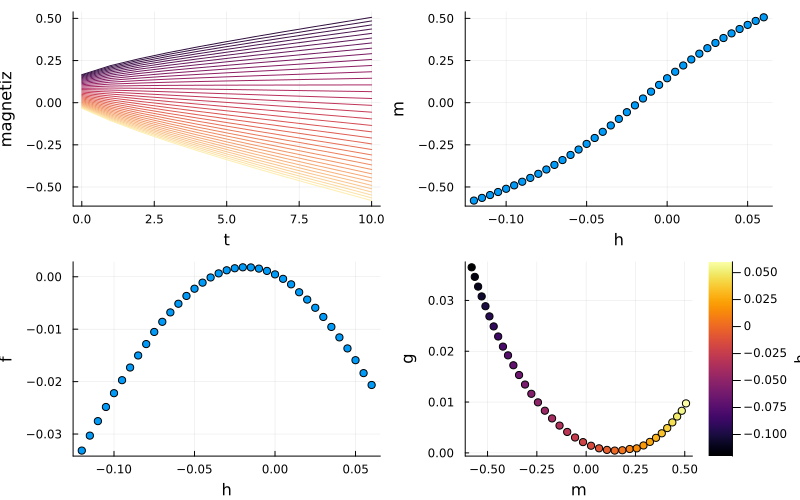

In [119]:
using LaTeXStrings
st = L"f(h)=-\frac1N\log\sum_\sigma w(\sigma)e^{h\sum_i\sigma_i^T}=\min_m\{g(m)-mh\},\quad g(m)=f(h(m))+mh(m)"
display(st)
plot(pl, pl1, pl2, pl4, layout=(2,2), size=(800,500))

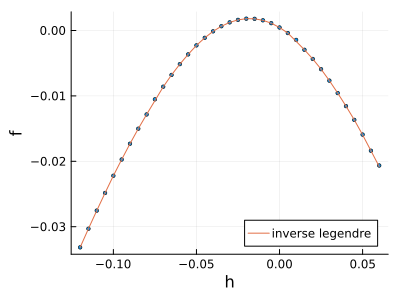

In [111]:
ff = zeros(length(hs))
for i in eachindex(hs)
   ff[i] = minimum(gs[j]-ms[j]*hs[i] for j in eachindex(hs)) 
end
plot!(deepcopy(pl2), hs, ff, label="inverse legendre", size=(400,300), legend=:bottomright)

In [121]:
jldsave("plot_data/glauber_large_deviations.jld2"; T, J, β, m⁰, hs, magnetizs, ms, fs, gs);